In [ ]:
a = [0,1]
print(a[0])

0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/weights

/content/drive/MyDrive/Colab Notebooks/weights


**Các thư viện cần thiết**

In [ ]:
!pip install tensorflow_addons
!pip install --quiet vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import warnings


from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3, DenseNet201, MobileNet, InceptionResNetV2, Xception	
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Input, concatenate
from keras.engine.training import model_serialization
from keras.regularizers import l2
from keras.utils import plot_model
from keras import optimizers
from keras import regularizers

from skimage import exposure
import tensorflow_addons as tfa

In [ ]:
warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.11.0


# **Chuẩn bị dữ liệu huấn luyện**

In [ ]:
categories = ['Normal', 'Doubtful', 'Mild', 'Moderate', 'Severe']

label_dict = {
    'Normal': 0,
    'Doubtful': 1,
    'Mild': 2,
    'Moderate': 3,
    'Severe': 4
}

print(label_dict)

{'Normal': 0, 'Doubtful': 1, 'Mild': 2, 'Moderate': 3, 'Severe': 4}


In [ ]:
import cv2

img_size = 224
data = []
label = []
#Folder 1
data_path_1 = '/content/drive/My Drive/gMedicalAI/Knee X-ray Images/MedicalExpert-II'
for category in categories:
  folder_path = os.path.join(data_path_1,category)
  print(folder_path)
  img_names = os.listdir(folder_path)
      
  for img_name in img_names:
    img_path = os.path.join(folder_path,img_name)
    img = cv2.imread(img_path)

    # Chuyển ảnh sang không gian màu Lab
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Tách các kênh màu
    l, a, b = cv2.split(lab)

    # Tạo đối tượng CLAHE cho các kênh màu
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_l = clahe.apply(l)
    clahe_a = clahe.apply(a)
    clahe_b = clahe.apply(b)

    # Kết hợp các kênh màu đã được xử lý
    lab_clahe = cv2.merge((clahe_l, clahe_a, clahe_b))

    # Chuyển đổi lại sang không gian màu RGB
    result = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    resized = cv2.resize(result,(img_size,img_size))
    data.append(resized)
    label.append(label_dict[category])

/content/drive/My Drive/gMedicalAI/Knee X-ray Images/MedicalExpert-II/Normal
/content/drive/My Drive/gMedicalAI/Knee X-ray Images/MedicalExpert-II/Doubtful
/content/drive/My Drive/gMedicalAI/Knee X-ray Images/MedicalExpert-II/Mild
/content/drive/My Drive/gMedicalAI/Knee X-ray Images/MedicalExpert-II/Moderate
/content/drive/My Drive/gMedicalAI/Knee X-ray Images/MedicalExpert-II/Severe


In [ ]:
print(len(data), len(label))

1650 1650


In [ ]:
data = np.array(data)
label = np.array(label)

encoder = LabelBinarizer()
label = encoder.fit_transform(label)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255,
                                zoom_range=.25,
                                shear_range=.25,
                                horizontal_flip=True,
                                rotation_range=40,)

val_gen = ImageDataGenerator(rescale=1./255)

train_set = train_gen.flow(X_train, y_train)
val_set = val_gen.flow(X_val, y_val)
test_set = val_gen.flow(X_test, y_test)

# **Huấn luyện mô hình**

In [ ]:
InceptionV3_model = InceptionV3(weights = 'imagenet', include_top = False, 
                    input_shape = (224, 224, 3))

DenseNet201_model = DenseNet201(weights = 'imagenet', include_top = False,
                    input_shape = (224, 224, 3))

MobileNet_model = MobileNet(weights = 'imagenet', include_top = False,
                    input_shape = (224, 224, 3))

input_tensor = Input(shape=(224, 224, 3))

In [ ]:
learning_rate = 1e-4

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc',
                                                 factor = 0.5,
                                                 patience = 5,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc',
                                                 min_delta = 1e-4,
                                                 patience = 12,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

In [ ]:
def encode(array):
  new_array = []
  for i in array:
    index = np.where(i == np.amax(i))[0][0]
    i[index] = int(1)
    for j in range(len(i)):
      if j == index:
        continue
      i[j] = int(0)
    new_array.append(i)
  return new_array

### Mô hình InceptionV3 + DenseNet201

In [ ]:
InceptionV3_output = InceptionV3_model(input_tensor)
InceptionV3_output = Flatten()(InceptionV3_output)
InceptionV3_output = BatchNormalization()(InceptionV3_output)
InceptionV3_output = Dropout(0.5)(InceptionV3_output)
InceptionV3_output = Dense(1000, activation='relu', kernel_regularizer=regularizers.l2())(InceptionV3_output)

DenseNet201_output = DenseNet201_model(input_tensor)
DenseNet201_output = Flatten()(DenseNet201_output)
DenseNet201_output = BatchNormalization()(DenseNet201_output)
DenseNet201_output = Dropout(0.5)(DenseNet201_output)
DenseNet201_output = Dense(1000, activation='relu', kernel_regularizer=regularizers.l2())(DenseNet201_output)

In [ ]:
merged_InceptionV3_DenseNet201 = concatenate([DenseNet201_output, InceptionV3_output])
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2())(merged_InceptionV3_DenseNet201)
predictions_InceptionV3_DenseNet201 = Dense(5, activation='softmax')(x)

# Khởi tạo model tổng thể
model_InceptionV3_DenseNet201 = Model(inputs=input_tensor, outputs=predictions_InceptionV3_DenseNet201)

In [ ]:
model_InceptionV3_DenseNet201.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet201 (Functional)       (None, 7, 7, 1920)   18321984    ['input_4[0][0]']                
                                                                                                  
 inception_v3 (Functional)      (None, 5, 5, 2048)   21802784    ['input_4[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 94080)        0           ['densenet201[0][0]']        

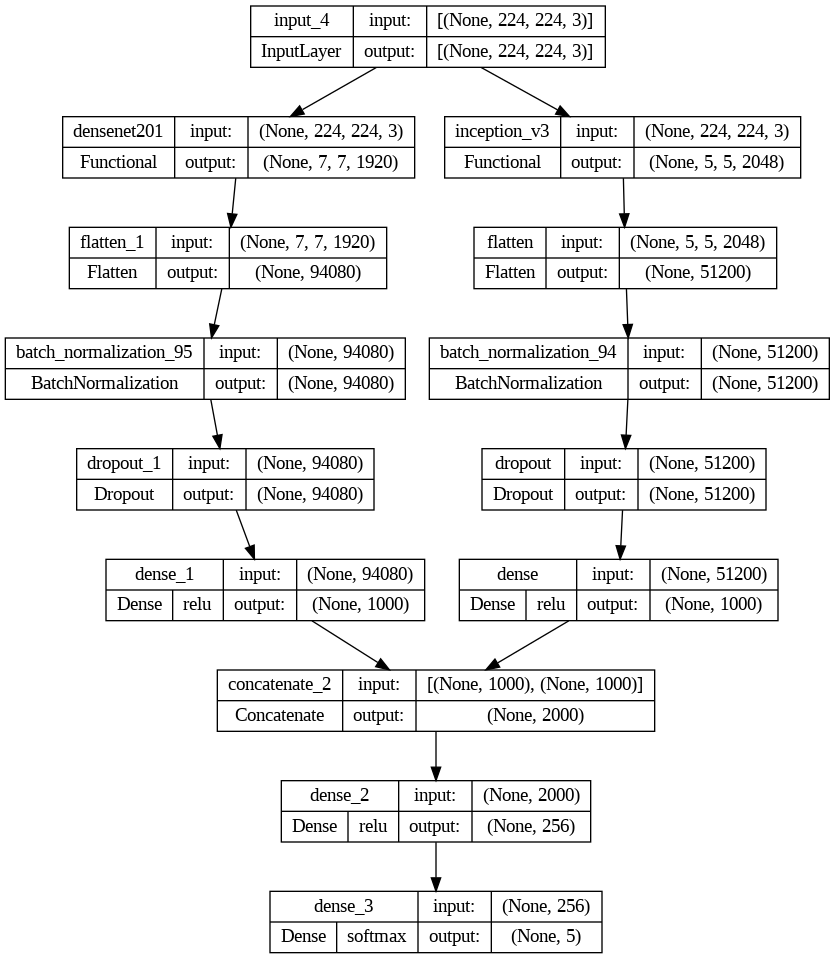

In [ ]:
plot_model(model_InceptionV3_DenseNet201, show_shapes=True, show_layer_activations=True)

In [ ]:
model_InceptionV3_DenseNet201.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=learning_rate),
                    metrics=['acc'])

In [ ]:
filepath="model_InceptionV3_DenseNet201.h5"

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = filepath,
                                                  monitor = 'val_acc', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')
callbacks = [earlystopping, reduce_lr, checkpointer]

hist_InceptionV3_DenseNet201 = model_InceptionV3_DenseNet201.fit(train_set,
                             epochs = 100,
                             batch_size = 16,
                             verbose=1,
                             validation_data = val_set,
                              callbacks = callbacks)


Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 41.8949 - acc: 0.4356
Epoch 1: val_acc improved from -inf to 0.35985, saving model to model_InceptionV3_DenseNet201.h5
33/33 [==============================] - 90s 1s/step - loss: 41.8949 - acc: 0.4356 - val_loss: 39.9687 - val_acc: 0.3598 - lr: 1.0000e-04
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 36.4590 - acc: 0.5795
Epoch 2: val_acc improved from 0.35985 to 0.48106, saving model to model_InceptionV3_DenseNet201.h5
33/33 [==============================] - 39s 1s/step - loss: 36.4590 - acc: 0.5795 - val_loss: 35.6095 - val_acc: 0.4811 - lr: 1.0000e-04
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 33.8964 - acc: 0.6269
Epoch 3: val_acc improved from 0.48106 to 0.53788, saving model to model_InceptionV3_DenseNet201.h5
33/33 [==============================] - 42s 1s/step - loss: 33.8964 - acc: 0.6269 - val_loss: 33.3531 - val_acc: 0.5379 - lr: 1.0000e-04
Epoch 4/100
33/3

In [ ]:
model_InceptionV3_DenseNet201.save('model_InceptionV3_DenseNet201_weights.h5')

In [ ]:
save_model_InceptionV3_DenseNet201 = tf.keras.models.load_model("model_InceptionV3_DenseNet201_weights.h5")

In [ ]:
save_score_InceptionV3_DenseNet201 = save_model_InceptionV3_DenseNet201.evaluate(test_set)
print(save_score_InceptionV3_DenseNet201)
print('-------------------------------------')

11/11 [==============================] - 7s 207ms/step - loss: 9.0095 - acc: 0.8485
[9.009506225585938, 0.8484848737716675]
-------------------------------------


In [ ]:
rs_InceptionV3_DenseNet201 = encode(save_model_InceptionV3_DenseNet201.predict(X_test/255.0).tolist())
print('Model accuracy InceptionV3 + DenseNet201: ', accuracy_score(rs_InceptionV3_DenseNet201, y_test))
print('-------------------------------------')

11/11 [==============================] - 8s 205ms/step
Model accuracy InceptionV3 + DenseNet201:  0.8484848484848485
-------------------------------------


In [ ]:
print('InceptionV3 + DenseNet201:')
print(classification_report(y_test, rs_InceptionV3_DenseNet201))

InceptionV3 + DenseNet201:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       114
           1       0.77      0.84      0.80        89
           2       0.85      0.56      0.67        50
           3       0.91      0.93      0.92        44
           4       0.84      0.97      0.90        33

   micro avg       0.85      0.85      0.85       330
   macro avg       0.85      0.84      0.84       330
weighted avg       0.85      0.85      0.84       330
 samples avg       0.85      0.85      0.85       330

